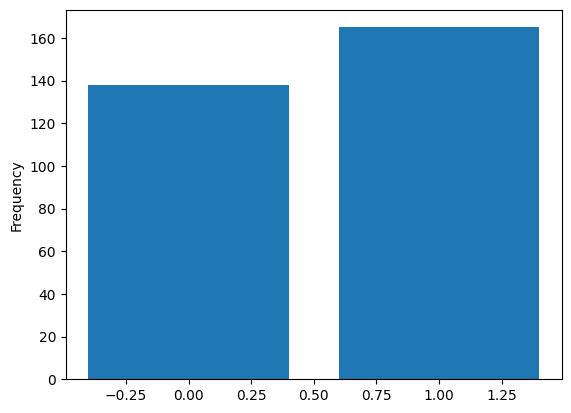

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2


In [3]:
import pandas as pd

heart = pd.read_csv("data/raw_dataset/heart.csv")

from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt

# separate the target variable from the features
heart_target = heart['output']
heart_data = heart.drop('output', axis=1)

# plot the class distribution
class_dist = pd.Series(heart_target).value_counts()
plt.bar(class_dist.index, class_dist)
plt.ylabel("Frequency")
plt.show()

heart_data.head()


In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# list all numerical features that we want to re-scale
numeric_features = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
numeric_transformer = Pipeline([ ('scaler', StandardScaler()) ])

# list all categorical features that we want to encode using OneHotEncoder
categorical_features = ['cp', 'restecg', 'restecg', 'caa', 'thall']
categorical_transformer = Pipeline([ ('onehot', OneHotEncoder()) ])

# list all ordinal features that we want to encode using OrdinalEncoder
ordinal_features = ['sex',  'fbs', 'exng']
ordinal_transformer = Pipeline([ ('ordinal', OrdinalEncoder()) ])

# define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features)])

display(preprocessor.fit_transform(heart_data))

# display(preprocessor.fit_transform(X))
# display(y)
# # Filter y_test to contain only 0 and 1 values
# filtered_y = y[y.isin([0, 1])]
# display(filtered_y.values)

array([[ 0.9521966 ,  0.76395577, -0.25633371, ...,  1.        ,
         1.        ,  0.        ],
       [-1.91531289, -0.09273778,  0.07219949, ...,  1.        ,
         0.        ,  0.        ],
       [-1.47415758, -0.09273778, -0.81677269, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.50364073,  0.70684287, -1.029353  , ...,  1.        ,
         1.        ,  0.        ],
       [ 0.29046364, -0.09273778, -2.2275329 , ...,  1.        ,
         0.        ,  1.        ],
       [ 0.29046364, -0.09273778, -0.19835726, ...,  0.        ,
         0.        ,  0.        ]])

In [6]:
#define function for computing average roc for cross validation
#see http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
from numpy import interp
from sklearn.metrics import roc_curve, auc

def avg_roc(cv, estimator, data, target, pos_label):
    mean_fpr = np.linspace(0, 1, 100) # = [0.0, 0.01, 0.02, 0.03, ... , 0.99, 1.0]
    tprs = []
    aucs = []
    
    for train_indices, test_indices in cv.split(data, target):
        train_data = data.iloc[train_indices]
        train_target = target[train_indices]
        estimator.fit(train_data, train_target)

        test_data = data.iloc[test_indices]
        test_target = target[test_indices]
        decision_for_each_class = estimator.predict_proba(test_data)#have to use predict_proba or decision_function 
    
        fpr, tpr, thresholds = roc_curve(test_target, decision_for_each_class[:,1], pos_label=pos_label)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0 # tprs[-1] access the last element
        aucs.append(auc(fpr, tpr))
        
        #plt.plot(fpr, tpr)# plot for each fold
        
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0 # set the last tpr to 1
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    return mean_fpr, mean_tpr, mean_auc, std_auc

<>:21: SyntaxWarning: invalid escape sequence '\p'
<>:26: SyntaxWarning: invalid escape sequence '\p'
<>:21: SyntaxWarning: invalid escape sequence '\p'
<>:26: SyntaxWarning: invalid escape sequence '\p'
C:\Users\I573015\AppData\Local\Temp\ipykernel_18164\2995706400.py:21: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(mean_fpr, mean_tpr, label='{}-NN (AUC: {:.3f} $\pm$ {:.3f})'.format(n_neighbour, mean_auc, std_auc))
C:\Users\I573015\AppData\Local\Temp\ipykernel_18164\2995706400.py:26: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(mean_fpr, mean_tpr, label='DecisonTree (AUC: {:.3f} $\pm$ {:.3f})'.format(mean_auc, std_auc))


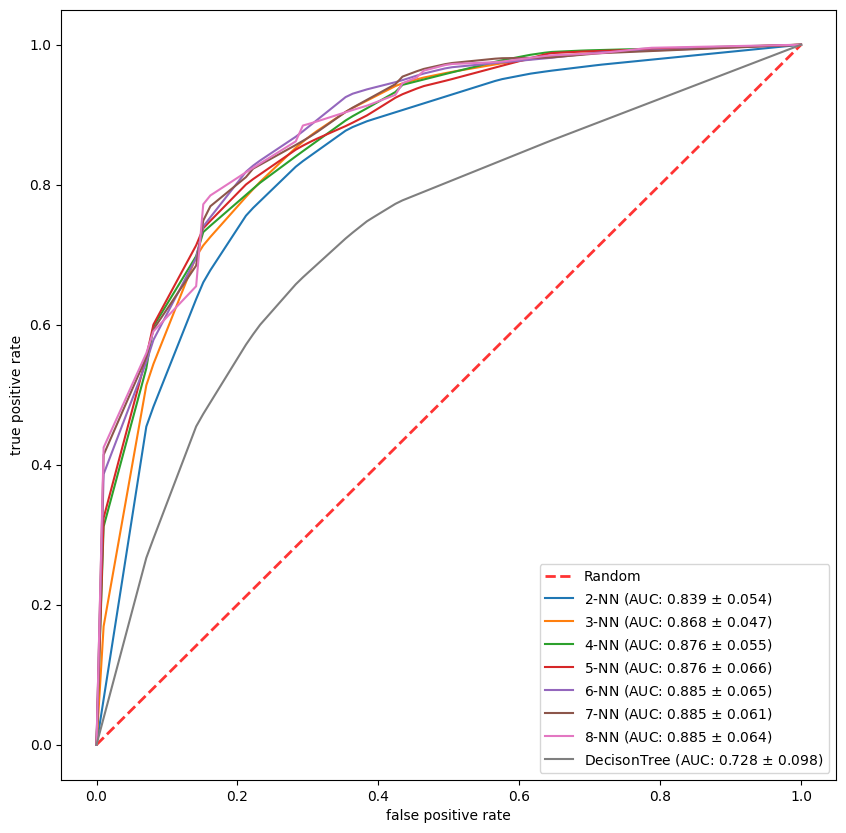

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

# define the cross validation folds
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# create the pipeline, we will set the estimator later
pipeline = Pipeline([ ('preprocessing', preprocessor), ('estimator', None) ])

# setup a figure
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random', alpha=.8) # draw diagonal

# KNN
pipeline.set_params(estimator=KNeighborsClassifier())
for n_neighbour in [2,3,4,5,6,7,8]:
    pipeline.set_params(estimator__n_neighbors=n_neighbour)
    mean_fpr, mean_tpr, mean_auc, std_auc = avg_roc(cv, pipeline, heart_data, heart_target, 1)
    plt.plot(mean_fpr, mean_tpr, label='{}-NN (AUC: {:.3f} $\pm$ {:.3f})'.format(n_neighbour, mean_auc, std_auc))
    
# Decision Tree
pipeline.set_params(estimator=DecisionTreeClassifier())
mean_fpr, mean_tpr, mean_auc, std_auc = avg_roc(cv, pipeline, heart_data, heart_target, 1)
plt.plot(mean_fpr, mean_tpr, label='DecisonTree (AUC: {:.3f} $\pm$ {:.3f})'.format(mean_auc, std_auc))

# show the plot
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend()
plt.show()

In [11]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

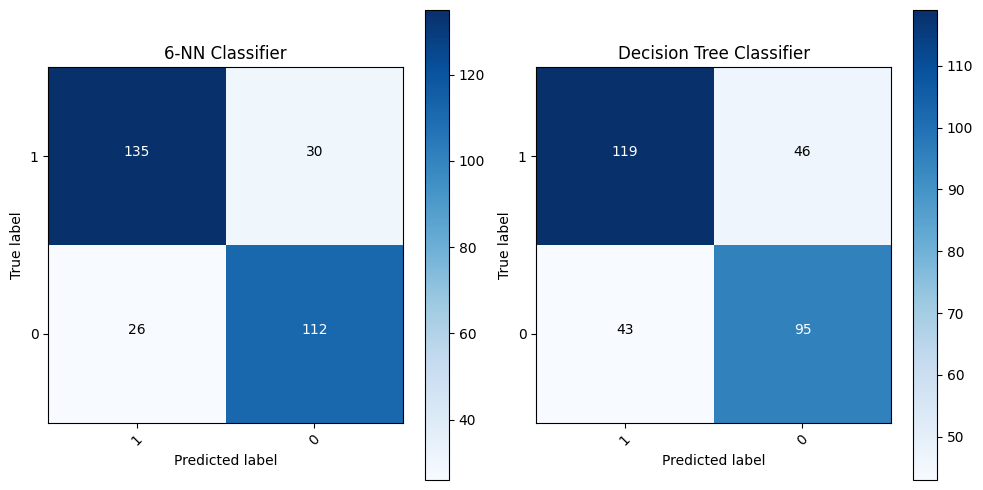

Classification Report for 6-NN Classifier:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       138
           1       0.84      0.82      0.83       165

    accuracy                           0.82       303
   macro avg       0.81      0.81      0.81       303
weighted avg       0.82      0.82      0.82       303

Classification Report for Decision Tree Classifier:
              precision    recall  f1-score   support

           0       0.67      0.69      0.68       138
           1       0.73      0.72      0.73       165

    accuracy                           0.71       303
   macro avg       0.70      0.70      0.70       303
weighted avg       0.71      0.71      0.71       303



In [12]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

plt.figure(figsize=(10,5))

classes = heart_target.unique()

# KNN
plt.subplot(1,2,1)
pipeline.set_params(estimator=KNeighborsClassifier(6))
prediction = cross_val_predict(pipeline, heart_data, heart_target, cv=cv)
cnf_matrix = confusion_matrix(heart_target, prediction, labels=classes)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=classes, title='6-NN Classifier')
rep_knn = classification_report(heart_target, prediction)

# Decision Tree
plt.subplot(1,2,2)
pipeline.set_params(estimator=DecisionTreeClassifier())
prediction = cross_val_predict(pipeline, heart_data, heart_target, cv=cv)
cnf_matrix = confusion_matrix(heart_target, prediction, labels=classes)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=classes, title='Decision Tree Classifier')
rep_dt = classification_report(heart_target, prediction)

plt.show()

print("Classification Report for 6-NN Classifier:")
print(rep_knn)

print("Classification Report for Decision Tree Classifier:")
print(rep_dt)

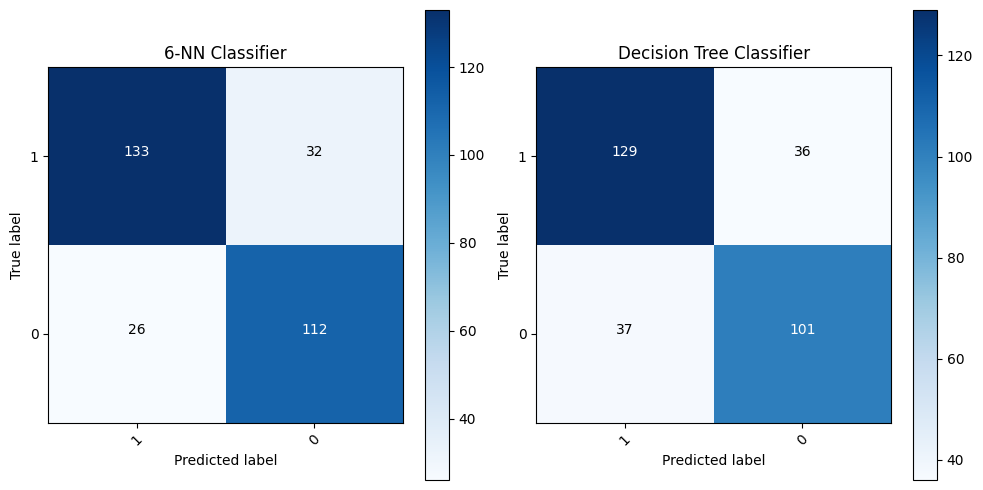

Classification Report for 6-NN Classifier:
              precision    recall  f1-score   support

           0       0.78      0.81      0.79       138
           1       0.84      0.81      0.82       165

    accuracy                           0.81       303
   macro avg       0.81      0.81      0.81       303
weighted avg       0.81      0.81      0.81       303

Classification Report for Decision Tree Classifier:
              precision    recall  f1-score   support

           0       0.74      0.73      0.73       138
           1       0.78      0.78      0.78       165

    accuracy                           0.76       303
   macro avg       0.76      0.76      0.76       303
weighted avg       0.76      0.76      0.76       303



In [13]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


# create a new pipeline with balancing
pipeline = Pipeline([ ('preprocessing', preprocessor), ('balancing', RandomOverSampler()), ('estimator', None) ])

plt.figure(figsize=(10,5))

classes = heart_target.unique()

# KNN
plt.subplot(1,2,1)
pipeline.set_params(estimator=KNeighborsClassifier(6))
prediction = cross_val_predict(pipeline, heart_data, heart_target, cv=cv)
cnf_matrix = confusion_matrix(heart_target, prediction, labels=classes)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=classes, title='6-NN Classifier')
rep_knn = classification_report(heart_target, prediction)

# Decision Tree
plt.subplot(1,2,2)
pipeline.set_params(estimator=DecisionTreeClassifier())
prediction = cross_val_predict(pipeline, heart_data, heart_target, cv=cv)
cnf_matrix = confusion_matrix(heart_target, prediction, labels=classes)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=classes, title='Decision Tree Classifier')
rep_dt = classification_report(heart_target, prediction)

plt.show()

print("Classification Report for 6-NN Classifier:")
print(rep_knn)

print("Classification Report for Decision Tree Classifier:")
print(rep_dt)

In [14]:
pipeline.set_params(estimator=KNeighborsClassifier(6))
prediction = cross_val_predict(pipeline, heart_data, heart_target, cv=cv)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(heart_target, prediction, labels=heart_target.unique())
cost = cm[0][1] * 100 + cm[1][0] * 1
acc = accuracy_score(heart_target, prediction)

print("6-NN with accuracy of {} and cost {}".format(acc, cost))

6-NN with accuracy of 0.7986798679867987 and cost 3724


In [15]:
pipeline.set_params(estimator=DecisionTreeClassifier())
prediction = cross_val_predict(pipeline, heart_data, heart_target, cv=cv)

cm = confusion_matrix(heart_target, prediction, labels=heart_target.unique())
cost = cm[0][1] * 100 + cm[1][0] * 1
acc = accuracy_score(heart_target, prediction)

print("Decision tree with accuracy of {} and cost {}".format(acc, cost))

Decision tree with accuracy of 0.7392739273927392 and cost 4336
